# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2024, 5)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2013


In [5]:
if year is None:
    year = cur_year

if last_month is None:
    if year == cur_year:
        last_month = 3
    else:
        last_month = 12

if template is None:
    if year >= 2023:
        template = '2023-PATH-Monthly-Ridership-Report.tabula-template.json'
    else:
        template = 'PATH-Monthly-Ridership-Report.json'

In [6]:
pdf = f'data/{year}-PATH-Monthly-Ridership-Report.pdf'
pdf

'data/2013-PATH-Monthly-Ridership-Report.pdf'

In [7]:
with open(f'templates/{template}', 'r') as f:
    rects = json.load(f)
rects

[{'y1': 121.284, 'x1': 70.016, 'y2': 245.247, 'x2': 568.926},
 {'y1': 261.316, 'x1': 71.546, 'y2': 407.469, 'x2': 569.691},
 {'y1': 482.459, 'x1': 70.781, 'y2': 603.36, 'x2': 568.161},
 {'y1': 620.96, 'x1': 70.781, 'y2': 761.757, 'x2': 569.691}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[121.284, 70.016, 245.247, 568.926],
 [261.316, 71.546, 407.469, 569.691],
 [482.459, 70.781, 603.36, 568.161],
 [620.96, 70.781, 761.757, 569.691]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}

tables

Error importing jpype dependencies. Fallback to subprocess.


No module named 'jpype'


{1: [                    0          1       2       3       4       5
  0  Christopher Street    108,836   4,067   2,508   2,230   2,238
  1           9thStreet    125,017   4,452   3,336   3,034   3,028
  2          14thStreet    240,235   8,898   5,596   4,860   5,772
  3          23rdStreet    180,847   7,589   2,132   1,744   2,990
  4          33rdStreet    854,784  33,775  14,106  11,600  21,346
  5     UPTOWN SUBTOTAL  1,509,719  58,781  27,678  23,468  35,374
  6                 WTC    827,740  36,627   5,690   4,360   9,190
  7   NEW YORK SUBTOTAL  2,337,459  95,408  33,368  27,828  44,564,
                       0          1        2       3       4       5
  0               Newark    634,009   26,478   8,792   6,250   8,906
  1             Harrison    151,438    6,332   2,069   1,423   2,252
  2       Journal Square    613,952   24,117  12,382   8,808  11,370
  3         Grove Street    398,871   15,350   9,466   6,607   6,111
  4       Exchange Place    343,731   15,735   1

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 4:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 4 tables
Pg 2: 4 tables
Pg 3: 4 tables
Pg 4: 4 tables
Pg 5: 4 tables
Pg 6: 4 tables
Pg 7: 4 tables
Pg 8: 4 tables
Pg 9: 4 tables
Pg 10: 4 tables
Pg 11: 4 tables
Pg 12: 4 tables


12

In [12]:
avgs = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs['date'] = avgs.date.dt.date
avgs

,0,1,2,3,4,5,date
0,Christopher Street,"108,836","4,067","2,508","2,230","2,238",2013-01-01
1,9thStreet,"125,017","4,452","3,336","3,034","3,028",2013-01-01
2,14thStreet,"240,235","8,898","5,596","4,860","5,772",2013-01-01
3,23rdStreet,"180,847","7,589","2,132","1,744","2,990",2013-01-01
4,33rdStreet,"854,784","33,775","14,106","11,600","21,346",2013-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,"331,938","14,202","4,308","2,824","2,350",2013-12-01
5,Pavonia/ Newport,"473,789","18,468","10,893","7,344","5,668",2013-12-01
6,Hoboken,"638,037","25,170","15,374","8,901","3,456",2013-12-01
7,NEW JERSEY SUBTOTAL,"3,302,714","131,396","70,757","45,623","32,275",2013-12-01


In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

,station,total,avg weekday,avg sat,avg sun,avg holiday,month
0,Christopher Street,108836,4067,2508,2230,2238,2013-01-01
1,9thStreet,125017,4452,3336,3034,3028,2013-01-01
2,14thStreet,240235,8898,5596,4860,5772,2013-01-01
3,23rdStreet,180847,7589,2132,1744,2990,2013-01-01
4,33rdStreet,854784,33775,14106,11600,21346,2013-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,331938,14202,4308,2824,2350,2013-12-01
5,Pavonia/ Newport,473789,18468,10893,7344,5668,2013-12-01
6,Hoboken,638037,25170,15374,8901,3456,2013-12-01
7,NEW JERSEY SUBTOTAL,3302714,131396,70757,45623,32275,2013-12-01


In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station        object
total           int64
avg weekday     int64
avg sat         int64
avg sun         int64
avg holiday     int64
month          object
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[2:]
])
sums['date'] = sums.date.dt.date
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

,station,avg daily,total weekday,total sat,total sun,total holiday,month
0,Christopher Street,3511,85408,10031,8922,4475,2013-01-01
1,9thStreet,4033,93486,13342,12134,6055,2013-01-01
2,14thStreet,7750,186867,22386,19439,11543,2013-01-01
3,23rdStreet,5834,159364,8526,6978,5979,2013-01-01
4,33rdStreet,27574,709267,56426,46398,42693,2013-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,10708,298239,17231,14118,2350,2013-12-01
5,Pavonia/ Newport,15284,387829,43572,36720,5668,2013-12-01
6,Hoboken,20582,528580,61497,44504,3456,2013-12-01
7,NEW JERSEY SUBTOTAL,106539,2759299,283029,228111,32275,2013-12-01


In [17]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [18]:
sums.dtypes

station          object
avg daily         int64
total weekday     int64
total sat         int64
total sun         int64
total holiday     int64
month            object
dtype: object

In [19]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2013-01-01 Christopher Street        3511         4067     2508     2230   
           9thStreet                 4033         4452     3336     3034   
           14thStreet                7750         8898     5596     4860   
           23rdStreet                5834         7589     2132     1744   
           33rdStreet               27574        33775    14106    11600   
...                                   ...          ...      ...      ...   
2013-12-01 Exchange Place           10708        14202     4308     2824   
           Pavonia/ Newport         15284        18468    10893     7344   
           Hoboken                  20582        25170    15374     8901   
           NEW JERSEY SUBTOTAL     106539       131396    70757    45623   
           MONTHLY TOTAL           189808       233064   126160    85240   

                                avg holiday    total  total weekday  \
month      station                                                    
2013-01-01 Christopher Street          2238   108836          85408   
           9thStreet                   3028   125017          93486   
           14thStreet                  5772   240235         186867   
           23rdStreet                  2990   180847         159364   
           33rdStreet                 21346   854784         709267   
...                                     ...      ...            ...   
2013-12-01 Exchange Place              2350   331938         298239   
           Pavonia/ Newport            5668   473789         387829   
           Hoboken                     3456   638037         528580   
           NEW JERSEY SUBTOTAL        32275  3302714        2759299   
           MONTHLY TOTAL              58877  5884053        4894339   

                                total sat  total sun  total holiday  
month      station                                                   
2013-01-01 Christopher Street       10031       8922           4475  
           9thStreet                13342      12134           6055  
           14thStreet               22386      19439          11543  
           23rdStreet                8526       6978           5979  
           33rdStreet               56426      46398          42693  
...                                   ...        ...            ...  
2013-12-01 Exchange Place           17231      14118           2350  
           Pavonia/ Newport         43572      36720           5668  
           Hoboken                  61497      44504           3456  
           NEW JERSEY SUBTOTAL     283029     228111          32275  
           MONTHLY TOTAL           504639     426198          58877  

[204 rows x 10 columns]

In [20]:
path = f'data/{year}.pqt'
df.to_parquet(path)

In [21]:
import plotly.express as px
from IPython.display import Image

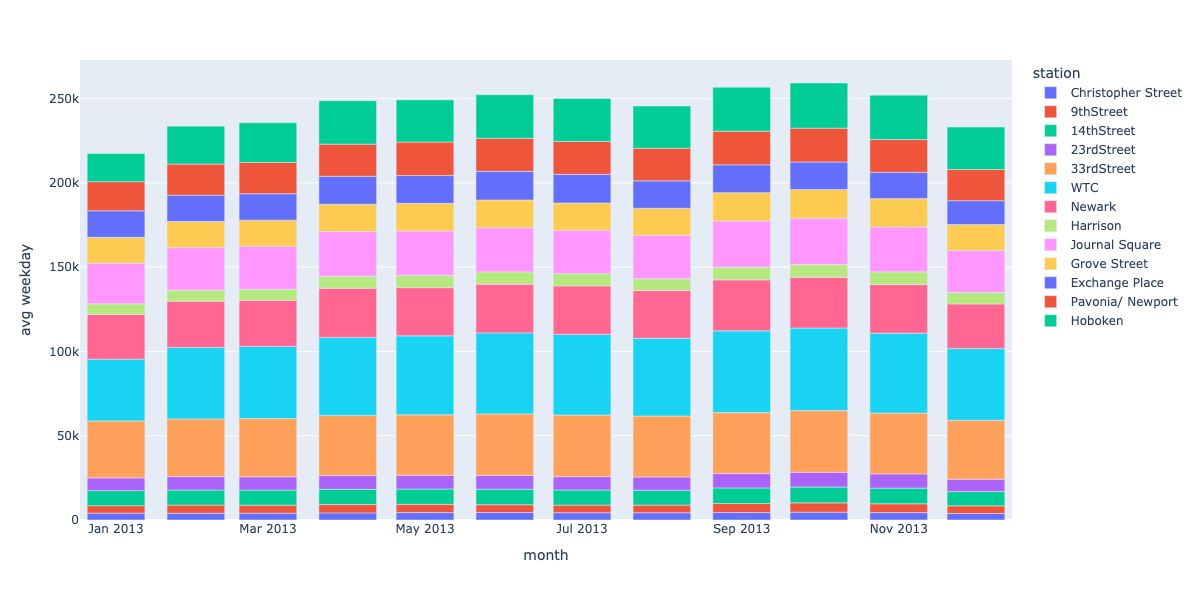

In [22]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))